In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.tensor as T

from torchvision import datasets, transforms
from tqdm.auto import tqdm
from IPython.display import Image, display

import matplotlib.pyplot as plt
from matplotlib import cm

from array2gif import write_gif

from time import time

In [5]:
torch.manual_seed(1)
device = 'cuda'

torch.cuda.is_available(), torch.__version__

(True, '1.4.0')

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [9]:
mnist = datasets.MNIST('/home/izpc/data/mnist', download=True, train=True, transform=transform)
X = mnist.data.to(device).float() / 255.
y = mnist.targets.to(device).float()

img_size = X.shape[-1]
flat_size = img_size * img_size
X = X.reshape(-1, flat_size)

X.shape ,y.shape, img_size, flat_size

(torch.Size([60000, 784]), torch.Size([60000]), 28, 784)

In [10]:
def make_data_sampler(sample_size):
    while True:
        idx = np.random.randint(len(X), size=sample_size)
        yield T(X[idx, :])

In [11]:
def plot_img(img):
    img = img.cpu().detach().numpy()
    plt.imshow(img.reshape(img_size, -1))

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, data_size, next_batch):
        super(Autoencoder, self).__init__()
        def unit(a, b):
            return [
                nn.Linear(a, b),
                nn.ReLU(),
                nn.BatchNorm1d(b),
            ]

        self.model = nn.Sequential(
            *unit(data_size, 500),
            *unit(500, 500),
            *unit(500, 400),
            *unit(400, 300),
            *unit(300, 10),
            *unit(10 , 300),
            *unit(300, 500),
            *unit(500, 500),
            nn.Linear(500, data_size),
            nn.Sigmoid()
        )
        
        self.next_batch = next_batch
        self.criterion = nn.BCELoss()
        self.loss_hist = []
        self.fixed_X_mappings = []
        
    def forward(self, X):
        return self.model(X)
    
    def optimize(self, num_steps, lr=0.001):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        for i in tqdm(range(num_steps)):
            if i % 100 == 0:
                mapping = self.__call__(X[:8]).detach().cpu().numpy()
                self.fixed_X_mappings.append(mapping)

            batch = next(self.next_batch)
            logits = self.__call__(batch)

            loss = self.criterion(logits, batch)
            loss.backward()
            self.optimizer.step()

            cpu_loss = loss.data.cpu().numpy()
            self.loss_hist.append(cpu_loss)

            if i % 500 == 0:
                print('[%i] Batch Loss: %f' % (i, cpu_loss))
            
    def plot_history(self):
        plt.plot(self.loss_hist)
    
    def plot_mapping(self, X):
        reconstructed = self.__call__(X)

        plot_size = 1.5
        
        num_imgs = X.shape[0]
        fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

        for i in range(num_imgs):
            l, r = (axs[0, i], axs[1, i]) if num_imgs > 1 else (axs[0], axs[1])

            l.imshow(X[i].reshape(img_size, -1).cpu().detach().numpy())
            r.imshow(reconstructed[i].reshape(img_size, -1).cpu().detach().numpy())

            l.set_xticklabels([])
            r.set_xticklabels([])
            l.set_yticklabels([])
            r.set_yticklabels([])

        fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [13]:
AE = Autoencoder(flat_size, make_data_sampler(100)).to(device)
AE

Autoencoder(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=400, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=400, out_features=300, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=300, out_features=10, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=10, out_features=300, bias=True)
    (16): ReLU()
    (17): BatchNorm1d(300, eps=1e-05, mome

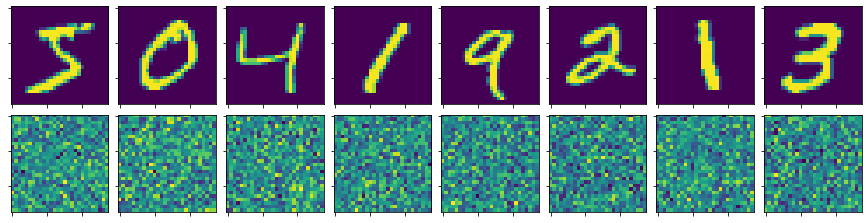

In [14]:
AE.plot_mapping(X[:8])

In [15]:
AE.optimize(10_000, lr=0.00001)

/home/izpc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


[0] Batch Loss: 0.732311
[500] Batch Loss: 0.639863
[1000] Batch Loss: 0.600794
[1500] Batch Loss: 0.569399
[2000] Batch Loss: 0.498556
[2500] Batch Loss: 0.431470
[3000] Batch Loss: 0.376015
[3500] Batch Loss: 0.311143
[4000] Batch Loss: 0.263855
[4500] Batch Loss: 0.224866
[5000] Batch Loss: 0.198202
[5500] Batch Loss: 0.183084
[6000] Batch Loss: 0.174376
[6500] Batch Loss: 0.166196
[7000] Batch Loss: 0.158482
[7500] Batch Loss: 0.150942
[8000] Batch Loss: 0.157208
[8500] Batch Loss: 0.153748
[9000] Batch Loss: 0.142719
[9500] Batch Loss: 0.134372



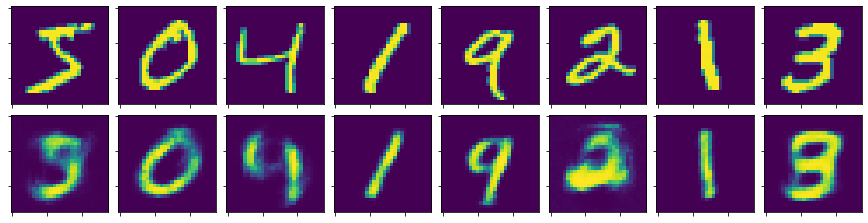

In [16]:
AE.plot_mapping(X[:8])

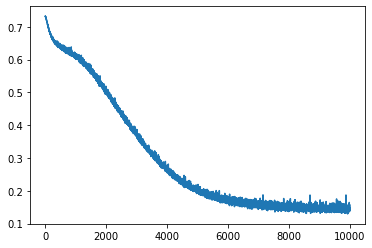

In [17]:
AE.plot_history()

In [35]:
'Num params %i' % np.sum(np.prod(t.shape) for t in AE.parameters())

/home/izpc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


'Num params 1769814'

In [18]:
frames = np.array(AE.fixed_X_mappings) \
    .reshape(-1, 8, 28, 28) \
    .transpose(0, 1, 3, 2) \
    .reshape(-1, 28 * 8, 28) \
    .swapaxes(-1, -2)

viridis = cm.get_cmap('viridis', 12)
frames = viridis(frames)[:,:,:,:3].transpose(0, 3, 1, 2)

frames = (frames * 255.).astype(int)
frames_list = [np.array(i).T for i in frames.tolist()]

In [19]:
frames.shape

(100, 3, 28, 224)

In [20]:
write_gif(frames_list, 'mnist_autoencode.gif', fps=100)
display(Image(url='mnist_autoencode.gif?%d' % time(), width=900))